# GRU WF App

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 12.5 MB/s eta 0:00:00


## Imports and Functions

In [2]:
import random, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Input

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from keras_tuner import HyperModel, HyperParameters
from keras_tuner.tuners import RandomSearch

random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)

In [3]:
def load_and_preprocess(data_path):
    
    data = pd.read_csv(data_path)
    
    data['temp_celsius'] = data['temp'] - 273.15
    # data['date'] = pd.to_datetime(data['dt_iso']).dt.date
    data['date'] = pd.to_datetime(data['dt_iso'], format='%Y-%m-%d %H:%M:%S +0000 UTC').dt.date
    data = data.drop(columns=['dt_iso', 'temp'])
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    
    return data.resample('D').mean()

def split_data_by_time(df, train_frac=0.7, val_frac=0.15):
    n = len(df)
    
    train_size = int(n * train_frac)
    val_size = int(n * val_frac)    
    test_size = n - train_size - val_size
    
    train_df = df[:train_size]    
    val_df = df[train_size:train_size+val_size]
    test_df = df[train_size+val_size:]
    
    return train_df, val_df, test_df


def scale_data(train_df, val_df, test_df, feature_columns, target_column):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    scaler_x.fit(train_df[feature_columns])
    scaler_y.fit(train_df[[target_column]])
    
    train_x = scaler_x.transform(train_df[feature_columns])
    val_x = scaler_x.transform(val_df[feature_columns])
    test_x = scaler_x.transform(test_df[feature_columns])
    
    train_y = scaler_y.transform(train_df[[target_column]])
    val_y = scaler_y.transform(val_df[[target_column]])
    test_y = scaler_y.transform(test_df[[target_column]])
    
    dump(scaler_x, 'scaler.joblib')
    
    return train_x, val_x, test_x, train_y.flatten(), val_y.flatten(), test_y.flatten(), scaler_x, scaler_y

def create_timewindow(X, y, time_steps=1):
    Xs, ys = [], []
    
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
        
    return np.array(Xs), np.array(ys), time_steps

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()


def evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y):

    y_train_pred_ = model.predict(X_train, verbose=0)
    y_val_pred = model.predict(X_val, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)

    true_y_train_pred = scaler_y.inverse_transform(y_train_pred_)
    true_y_val_pred = scaler_y.inverse_transform(y_val_pred)
    true_y_test_pred = scaler_y.inverse_transform(y_test_pred)

    true_y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    true_y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))
    true_y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    train_mse = mean_squared_error(true_y_train, true_y_train_pred)
    val_mse = mean_squared_error(true_y_val, true_y_val_pred)
    test_mse = mean_squared_error(true_y_test, true_y_test_pred)
    print("Train MSE:", train_mse, "Validation MSE:", val_mse, "Test MSE:", test_mse)
    return true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse



def plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps):
    plt.figure(dpi=200)
    plt.figure(figsize=(30, 10))
    
    # Train
    train_time = train_df.index[time_steps:]
    plt.plot(train_time, true_y_train, label='True Values (Train)', color='blue')
    plt.plot(train_time, true_y_train_pred, '--', label='Predicted Values (Train)', color='red')

    # Validation
    val_time = val_df.index[time_steps:]
    plt.plot(val_time, true_y_val, label='True Values (Validation)', color='green')
    plt.plot(val_time, true_y_val_pred, '--', label='Predicted Values (Validation)', color='orange')

    # Test
    test_time = test_df.index[time_steps:]
    plt.plot(test_time, true_y_test, label='True Values (Test)', color='purple')
    plt.plot(test_time, true_y_test_pred, '--', label='Predicted Values (Test)', color='pink')

    # Metrics
    plt.text(train_time.min(), true_y_train.max()*1.03, f"Train MSE: {train_mse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.98, f"Validation MSE: {val_mse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.93, f"Test MSE: {test_mse:.4f}", fontsize=12)

    plt.title('Actual and Predicted Values for All Data Sets')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

## Data Prep

In [4]:
data_path = "../malmo_weather_five_years.csv"

# load and preprocess data
df = load_and_preprocess(data_path)
print(df.head())

# features and target
feature_columns=[col for col in df.columns if col != 'temp_celsius']
target_column='temp_celsius'

# split data by time
train_df, val_df, test_df = split_data_by_time(df, train_frac=0.7, val_frac=0.15)
print("Train Sizes:", train_df.shape, "Validation Sizes:", val_df.shape, "Test Sizes:", test_df.shape)

# scaling
train_scaled_x, val_scaled_x, test_scaled_x, train_scaled_y, val_scaled_y, test_scaled_y, scaler_x, scaler_y = scale_data(train_df, val_df, test_df, feature_columns, target_column)

# time window
X_train, y_train, time_steps = create_timewindow(train_scaled_x, train_scaled_y, time_steps = 5)
X_val, y_val, time_steps = create_timewindow(val_scaled_x, val_scaled_y, time_steps = 5)
X_test, y_test, time_steps = create_timewindow(test_scaled_x, test_scaled_y, time_steps = 5)

input_shape = (X_train.shape[1], X_train.shape[2])

             humidity  wind_speed  clouds_all     pressure   dew_point  \
date                                                                     
2019-01-01  72.583333   17.350000   45.666667  1003.958333  274.824167   
2019-01-02  49.291667   16.275000   13.000000  1021.833333  266.507500   
2019-01-03  68.208333    6.525000   58.791667  1030.000000  269.981667   
2019-01-04  86.750000    8.279167   76.250000  1019.583333  275.467083   
2019-01-05  88.916667    6.129167   53.125000  1018.291667  274.827917   

            temp_celsius  
date                      
2019-01-01      6.366250  
2019-01-02      2.090833  
2019-01-03      1.695000  
2019-01-04      4.332500  
2019-01-05      3.298750  
Train Sizes: (1278, 6) Validation Sizes: (273, 6) Test Sizes: (275, 6)


##Model

In [5]:
model = Sequential([
        GRU(50, 
            input_shape=input_shape,
            kernel_regularizer=l2(0.001)),
            Dense(1)
    ])


optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mse'])

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50)                  │           8,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,601 (33.60 KB)

 Trainable params: 8,601 (33.60 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
start_time = datetime.datetime.now()

history = model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_val, y_val),
    batch_size=32,
    verbose=1,
    callbacks=early_stopping
)

end_time = datetime.datetime.now()

total_duration = end_time - start_time
print("Training Time:", total_duration)

Epoch 1/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.3986 - mse: 0.3893 - val_loss: 0.0540 - val_mse: 0.0455
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0400 - mse: 0.0318 - val_loss: 0.0357 - val_mse: 0.0285
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0255 - mse: 0.0186 - val_loss: 0.0199 - val_mse: 0.0136
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0154 - mse: 0.0094 - val_loss: 0.0131 - val_mse: 0.0076
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110 - mse: 0.0058 - val_loss: 0.0115 - val_mse: 0.0067
Epoch 6/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0095 - mse: 0.0048 - val_loss: 0.0109 - val_mse: 0.0066
Epoch 7/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - mse: 0.0046 - val_loss: 0.0103 - val_mse: 0.0064
Epoch 8/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0084 - mse: 0.0045 - val_loss: 0.0099 - val_mse: 0.0062
Epoch 9/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step -

In [7]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Train Loss: 0.0025831121020019054 Validation Loss: 0.0032336940057575703 Test Loss: 0.0026157943066209555


In [8]:
# RNN        Train Loss: 0.005940112750977278  Validation Loss: 0.008608177304267883  Test Loss: 0.01408026646822691
# LSTM       Train Loss: 0.0027570798993110657 Validation Loss: 0.0032699054572731256 Test Loss: 0.0026631003711372614
# LSTM hyper Train Loss: 0.002944508334621787  Validation Loss:  0.0035365233197808266  Test Loss: 0.002884679939597845
# GRU        Train Loss: 0.0025831121020019054 Validation Loss: 0.0032336940057575703 Test Loss: 0.0026157943066209555

In [9]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y)

Train MSE: 2.3050097404986793 Validation MSE: 2.9327086096823036 Test MSE: 2.3365426436949304


In [10]:
# RNN        Train MSE: 3.173135618953161  Validation MSE: 4.598381828182215  Test MSE: 7.5215032227643075
# LSTM       Train MSE: 2.3680083099711053 Validation MSE: 2.8627960229032854 Test MSE: 2.2773346647605055
# LSTM hyper Train MSE: 2.681002524055421  Validation MSE: 3.2521945379090402 Test MSE: 2.623278167190968
# GRU        Train MSE: 2.3050097404986793 Validation MSE: 2.9327086096823036 Test MSE: 2.3365426436949304

<Figure size 1280x960 with 0 Axes>

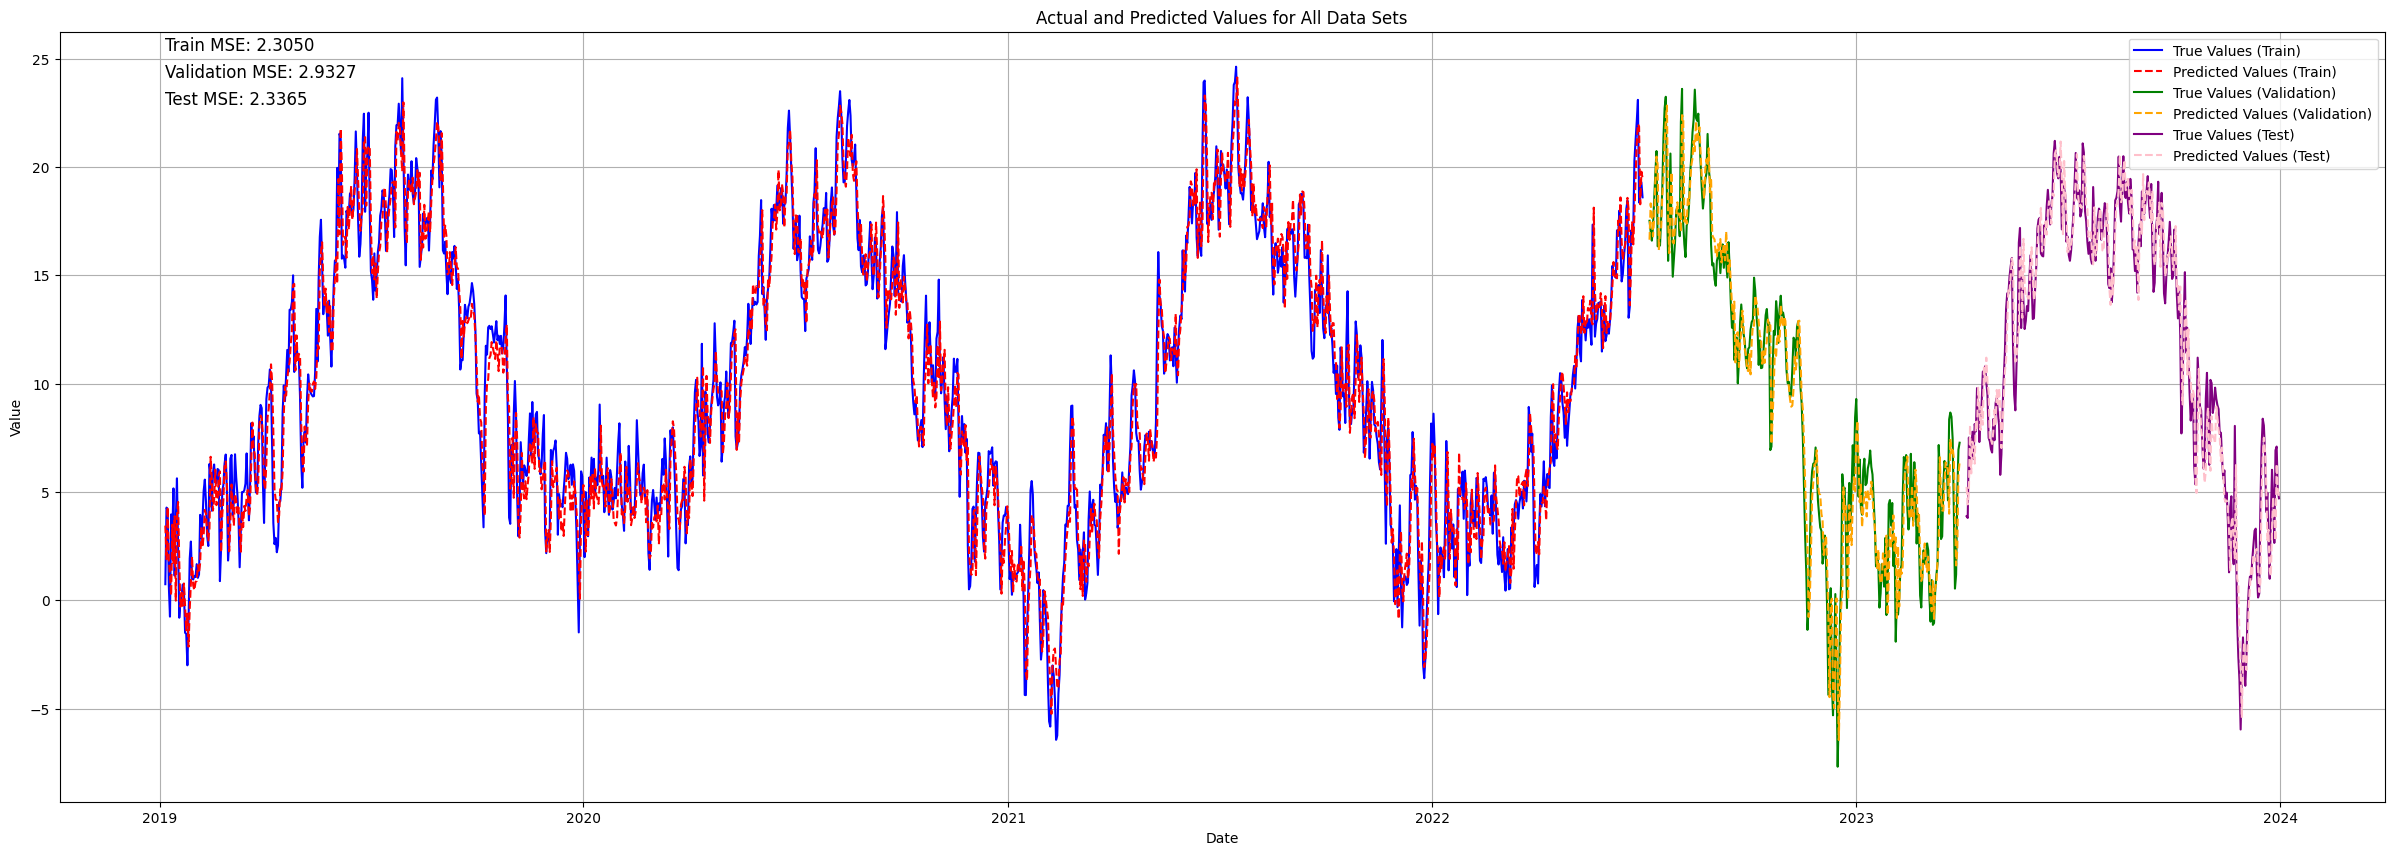

In [11]:
plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps)

## Perfomance Eval

### Hyperparameter Opt. RandomSearch

In [12]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=input_shape))

    for i in range(hp.Int('num_layers', 1, 5)):
        
        model.add(
            GRU(
                units=hp.Int('units_' + str(i),
                min_value=32,
                max_value=512, 
                step=32),
                return_sequences=(i < hp.Int('num_layers', 1, 5) - 1))
        )
        
        model.add(BatchNormalization())
        
        model.add(
            Dropout(hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1))
        )

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
                  loss='mean_squared_error',
                  metrics=['mse'])

    return model

In [13]:
random_search_tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='gru_tuning',
    overwrite=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

random_search_tuner.search(X_train, y_train,
                           epochs=250,
                           validation_data=(X_val, y_val),
                           callbacks=[early_stopping])

Trial 20 Complete [00h 00m 36s]
val_loss: 0.0058178044855594635

Best val_loss So Far: 0.003722070250660181
Total elapsed time: 00h 07m 24s


In [14]:
random_search_tuner.results_summary()

Results summary
Results in hyperparam_tuning/gru_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 15 summary
Hyperparameters:
num_layers: 1
units_0: 32
dropout_0: 0.0
learning_rate: 0.00038305416753732047
units_1: 320
dropout_1: 0.2
units_2: 32
dropout_2: 0.0
units_3: 352
dropout_3: 0.30000000000000004
units_4: 288
dropout_4: 0.30000000000000004
Score: 0.003722070250660181

Trial 09 summary
Hyperparameters:
num_layers: 1
units_0: 512
dropout_0: 0.4
learning_rate: 0.00010508976312300089
units_1: 160
dropout_1: 0.30000000000000004
units_2: 64
dropout_2: 0.2
units_3: 352
dropout_3: 0.0
units_4: 288
dropout_4: 0.30000000000000004
Score: 0.004116698168218136

Trial 10 summary
Hyperparameters:
num_layers: 3
units_0: 128
dropout_0: 0.1
learning_rate: 0.005808921978016473
units_1: 352
dropout_1: 0.4
units_2: 192
dropout_2: 0.30000000000000004
units_3: 256
dropout_3: 0.2
units_4: 256
dropout_4: 0.4
Score: 0.004345092922449112

Trial 18 summary
Hyperparameters:
nu

In [15]:
best_hps = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]

def print_hyperparameters(hyperparameters):
    hp_df = pd.DataFrame(list(hyperparameters.items()), columns=['Hyperparameter', 'Value'])
    print(hp_df)

print_hyperparameters(best_hps.values)

dump(best_hps, 'best_hps_gru.joblib') # model save

   Hyperparameter       Value
0      num_layers    1.000000
1         units_0   32.000000
2       dropout_0    0.000000
3   learning_rate    0.000383
4         units_1  320.000000
5       dropout_1    0.200000
6         units_2   32.000000
7       dropout_2    0.000000
8         units_3  352.000000
9       dropout_3    0.300000
10        units_4  288.000000
11      dropout_4    0.300000


['best_hps_gru.joblib']

In [16]:
best_model = random_search_tuner.get_best_models(num_models=1)[0]
best_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 32)                  │           3,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,905 (15.25 KB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 64 (256.00 B)

In [17]:
train_loss = best_model.evaluate(X_train, y_train, verbose=0)
val_loss = best_model.evaluate(X_val, y_val, verbose=0)
test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Train Loss: 0.0030919071286916733 Validation Loss: 0.003722070250660181 Test Loss: 0.002974678995087743


In [18]:
# RNN        Train Loss: 0.005940112750977278  Validation Loss: 0.008608177304267883  Test Loss: 0.01408026646822691
# LSTM      Train Loss: 0.0027570798993110657 Validation Loss: 0.0032699054572731256 Test Loss: 0.0026631003711372614
# LSTM hyper Train Loss: 0.002944508334621787  Validation Loss: 0.0035365233197808266 Test Loss: 0.002884679939597845
# GRU        Train Loss: 0.0026711546815931797 Validation Loss: 0.0031850545201450586 Test Loss: 0.0025750501081347466
# GRU  hyper Train Loss: 0.0030919071286916733 Validation Loss: 0.003722070250660181 Test Loss: 0.002974678995087743

In [19]:
best_model.save('weather_forecast_gru_tuned.keras')

In [20]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = evaluate_predictions(best_model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y)

Train MSE: 2.9831558308946065 Validation MSE: 3.5911539040279363 Test MSE: 2.8700513505659044


In [21]:
# RNN        Train MSE: 3.173135618953161  Validation MSE: 4.598381828182215  Test MSE: 7.5215032227643075
# LSTM       Train MSE: 2.3680083099711053 Validation MSE: 2.8627960229032854 Test MSE: 2.2773346647605055
# LSTM hyper Train MSE: 2.681002524055421  Validation MSE: 3.2521945379090402 Test MSE: 2.623278167190968
# GRU        Train MSE: 2.324467973622236 Validation MSE: 2.8202917686963107 Test MSE:  2.231743043182819
# GRU  hyper Train MSE: 2.9831558308946065 Validation MSE: 3.5911539040279363 Test MSE: 2.8700513505659044

<Figure size 1280x960 with 0 Axes>

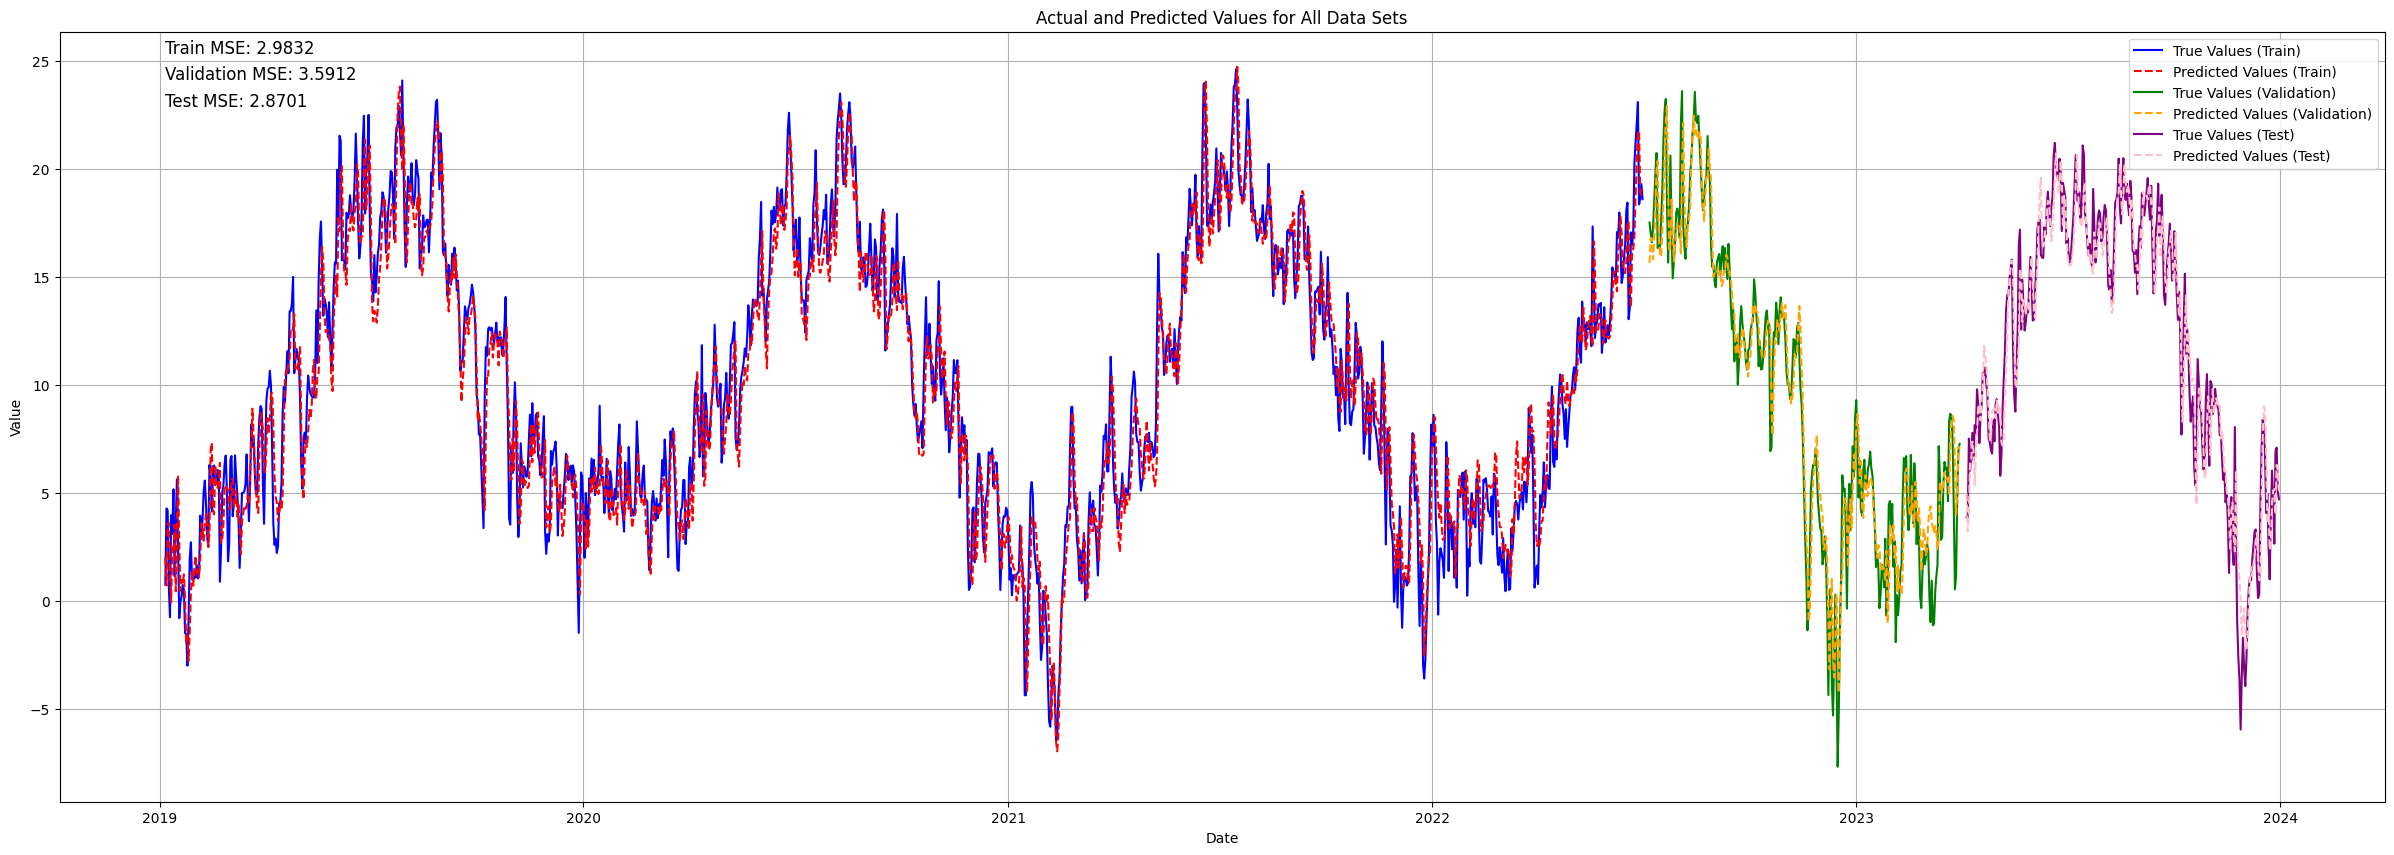

In [22]:
plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps)

### Hyperparameter Opt. GridSearch

In [23]:
from keras_tuner.tuners import GridSearch

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=input_shape))

    num_layers = hp.Int('num_layers', 1, 5)
    
    for i in range(num_layers):
        model.add(GRU(units=hp.Int('units_' + str(i), min_value=16, max_value=256, step=16),
                      return_sequences=(i < num_layers - 1)))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
                  loss='mean_squared_error',
                  metrics=['mse'])

    return model


grid_search_tuner = GridSearch(
    build_model,
    objective='val_loss',
    max_trials=20,# 50
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='gru_tuning',
    overwrite=True)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True)

In [24]:
grid_search_tuner.search(X_train, y_train,
                         epochs=250,
                         validation_data=(X_val, y_val),
                         callbacks=[early_stopping])

Trial 20 Complete [00h 00m 37s]
val_loss: 0.003882156452164054

Best val_loss So Far: 0.002950542839244008
Total elapsed time: 00h 13m 08s


In [26]:
best_hps = grid_search_tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = grid_search_tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [27]:
train_loss = best_model.evaluate(X_train, y_train, verbose=0)
val_loss = best_model.evaluate(X_val, y_val, verbose=0)
test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Train Loss: 0.0024218440521508455 Validation Loss: 0.002950542839244008 Test Loss: 0.0022607636637985706


In [28]:
# RNN         Train Loss: 0.005940112750977278  Validation Loss: 0.008608177304267883  Test Loss: 0.01408026646822691
# LSTM        Train Loss: 0.0027570798993110657 Validation Loss: 0.0032699054572731256 Test Loss: 0.0026631003711372614
# LSTM hyper Train Loss: 0.002944508334621787  Validation Loss: 0.0035365233197808266 Test Loss: 0.002884679939597845
# GRU        Train Loss: 0.0026711546815931797 Validation Loss: 0.0031850545201450586 Test Loss: 0.0025750501081347466
# GRU  hyper Train Loss: 0.003000599564984441  Validation Loss: 0.0034686243161559105 Test Loss: 0.003013251582160592
# GRU grid   Train Loss: 0.0023663335014134645 Validation Loss: 0.002950680907815695  Test Loss: 0.0022324821911752224

In [29]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = evaluate_predictions(best_model,
                                                                                                                                                 X_train,
                                                                                                                                                 y_train,
                                                                                                                                                 X_val,
                                                                                                                                                 y_val,
                                                                                                                                                 X_test,
                                                                                                                                                 y_test,
                                                                                                                                                 scaler_y)

Train MSE: 2.3366606116099202 Validation MSE: 2.846763813863778 Test MSE: 2.181246035722631


In [30]:
# RNN        Train MSE: 3.173135618953161  Validation MSE: 4.598381828182215  Test MSE: 7.5215032227643075
# LSTM       Train MSE: 2.3680083099711053 Validation MSE: 2.8627960229032854 Test MSE: 2.2773346647605055
# LSTM hyper Train MSE: 2.681002524055421  Validation MSE: 3.2521945379090402 Test MSE: 2.623278167190968
# GRU        Train MSE: 2.324467973622236 Validation MSE:  2.8202917686963107 Test MSE:  2.231743043182819
# GRU  hyper Train MSE: 2.895059672339221 Validation MSE:  3.346622464594937  Test MSE:  2.9072669097671744
# GRU grid   Train MSE: 2.2831027293019974 Validation MSE: 2.8468970232820157 Test MSE:  2.1539596425750744

<Figure size 1280x960 with 0 Axes>

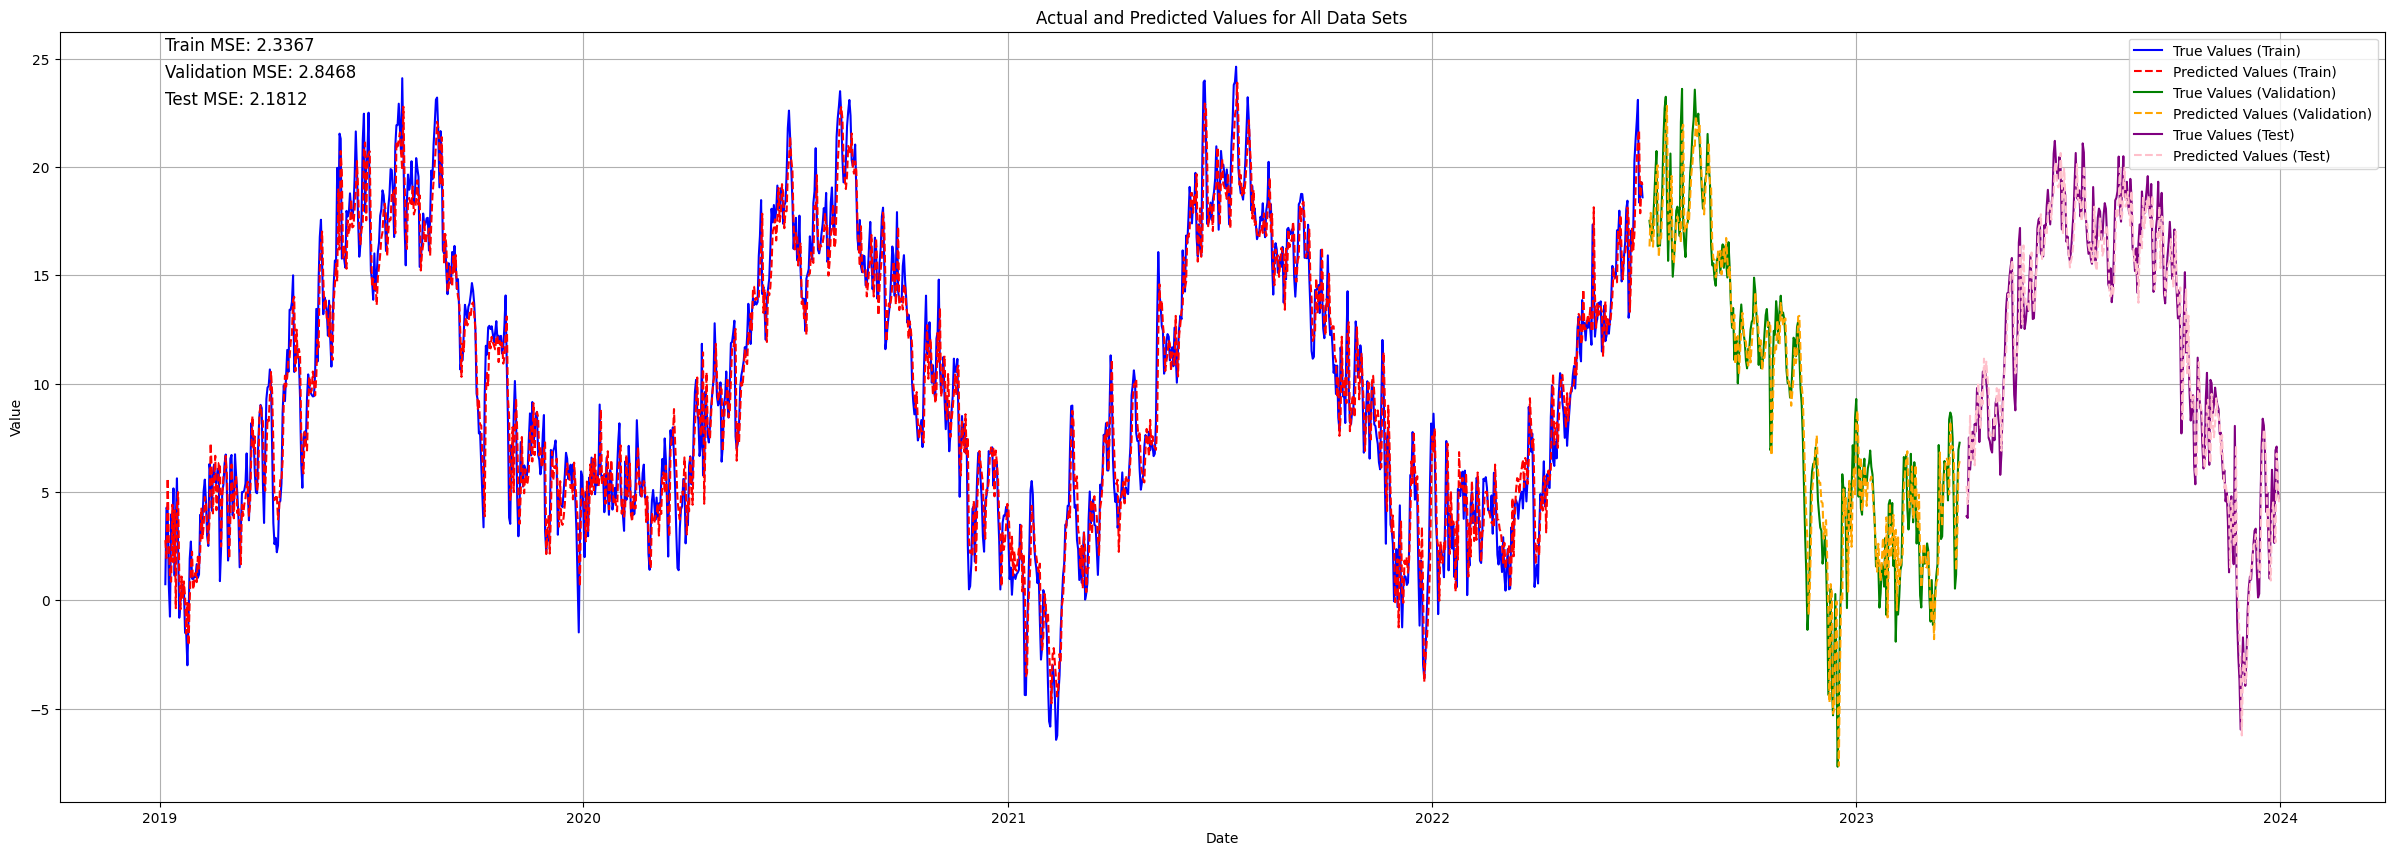

In [31]:
plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps)